## Predicting Flight Arrival Delays

This large dataset contains all the flights (for American airline companies) in and out of the United States in 2015. I want to see if we can predict the arrival delay of flights, but by only using the information/features that would be known at take-off. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

flights = pd.read_csv("../input/flight-delays/flights.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Dataset Visualisation

In [2]:
flights.shape

(5819079, 31)

Around 5.8 million dataset entries, and 31 features. I will definitely need to look at using a smaller subset of this data when experimenting with my models, as 5.8 million entries will surely slow down model fittings.

In [3]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
YEAR                   int64
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE                object
FLIGHT_NUMBER          int64
TAIL_NUMBER            object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED               int64
CANCELLED              int64
CANCELLATION_REASON    object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT

So we have the following types of features listed above: 10 integers, 5 strings (or 'objects'), and 16 floats.

To start off visualisation, let's take a look at the busiest airports in the US for both arrivals and departures.

Text(0.5, 1.0, 'Top 20 Busiest Destination Airports (2015)')

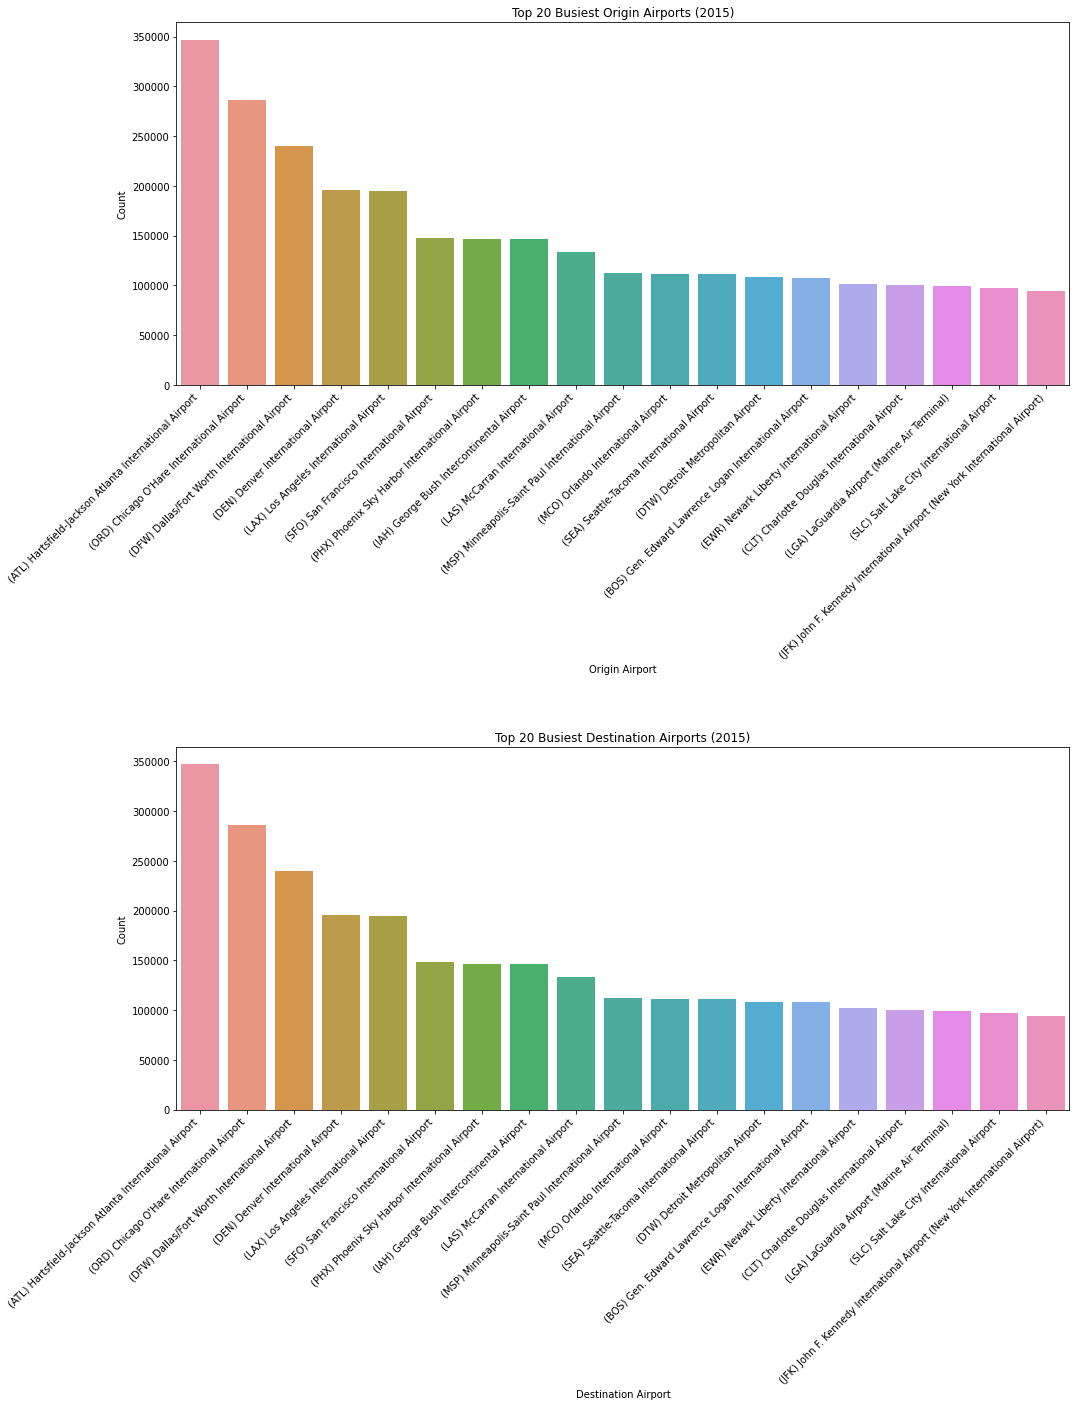

In [5]:
airport_names = pd.read_csv("../input/flight-delays/airports.csv")
airport_names = airport_names.set_index('IATA_CODE')
airport_names = airport_names.drop(['CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE'], axis=1)

origin_airport_counts = flights.ORIGIN_AIRPORT.value_counts()
origin_airport_counts_data = pd.DataFrame({'IATA_CODE': list(origin_airport_counts.index), 'COUNT': origin_airport_counts.values})
origin_airport_counts_data = origin_airport_counts_data.set_index("IATA_CODE")
origin_airport_counts_data = origin_airport_counts_data.join(airport_names)
origin_airport_counts_data['AIRLINE_CODE_NAME'] = "(" + origin_airport_counts_data.index.astype('str') + ") " + origin_airport_counts_data.AIRPORT
origin_airport_counts_data = origin_airport_counts_data[:19]

dest_airport_counts = flights.DESTINATION_AIRPORT.value_counts()
dest_airport_counts_data = pd.DataFrame({'IATA_CODE': list(dest_airport_counts.index), 'COUNT': dest_airport_counts.values})
dest_airport_counts_data = dest_airport_counts_data.set_index("IATA_CODE")
dest_airport_counts_data = dest_airport_counts_data.join(airport_names)
dest_airport_counts_data['AIRLINE_CODE_NAME'] = "(" + dest_airport_counts_data.index.astype('str') + ") " + dest_airport_counts_data.AIRPORT
dest_airport_counts_data = dest_airport_counts_data[:19]

fig, ax = plt.subplots(2, 1, figsize=(16,20))
fig.subplots_adjust(hspace=1)
barplot1 = sns.barplot(origin_airport_counts_data.AIRLINE_CODE_NAME, origin_airport_counts_data.COUNT, ax=ax[0])
barplot2 = sns.barplot(dest_airport_counts_data.AIRLINE_CODE_NAME, dest_airport_counts_data.COUNT, ax=ax[1])
barplot1.set_xticklabels(barplot1.get_xticklabels(), rotation=45, horizontalalignment='right')
barplot2.set_xticklabels(barplot2.get_xticklabels(), rotation=45, horizontalalignment='right')
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Origin Airport")
ax[0].set_title("Top 20 Busiest Origin Airports (2015)")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Destination Airport")
ax[1].set_title("Top 20 Busiest Destination Airports (2015)")

We can see from the above barplots that there is the same ordering of the Top 20 busiest airports for both arrivals and departures. How busy an airport is will likely play a role in both depatures delays and arrival delays, as busier airports will likely have to deal with emergencies, problems and faults more frequently.

What about the airline companies themselves? Let's look at the busiest airlines used for flights.

Text(0.5, 1.0, 'Most Popular Airlines for Flights (2015)')

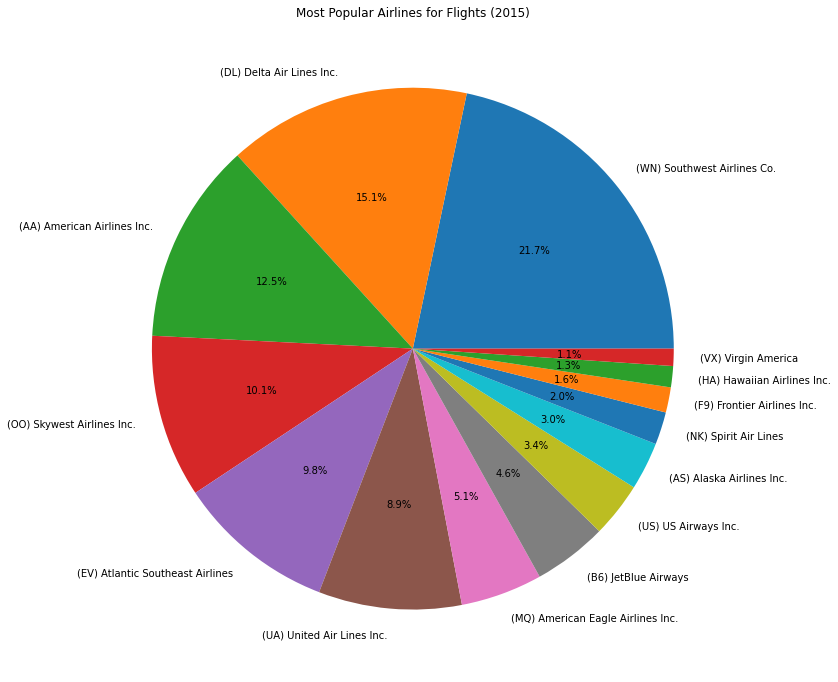

In [6]:
airline_counts = flights.AIRLINE.value_counts()
airline_names = pd.read_csv("../input/flight-delays/airlines.csv")
airline_names = airline_names.set_index("IATA_CODE")

airline_counts_data = pd.DataFrame({'IATA_CODE': list(airline_counts.index), 'COUNT': airline_counts.values})
airline_counts_data = airline_counts_data.set_index("IATA_CODE")

airline_counts_data = airline_counts_data.join(airline_names)
airline_counts_data['AIRLINE_CODE_NAME'] = "(" + airline_counts_data.index + ") " + airline_counts_data.AIRLINE

fig, ax = plt.subplots(figsize=(12,12))
ax.pie(airline_counts_data.COUNT, labels=airline_counts_data.AIRLINE_CODE_NAME, autopct='%1.1f%%')
ax.set_title("Most Popular Airlines for Flights (2015)")

It's very uncertain whether a busier airline will suffer more frequent delays than a less busy airline company. However this pie chart is a good insight into the most popular companies used, and the number of companies that operate within. Note that the dataset only contains flight data for American airline companies.

Next, we'll look at how the number of flights varies across the months of the year, and days of the week.

Text(0.5, 1.0, 'Busiest days of the week (2015) for flights')

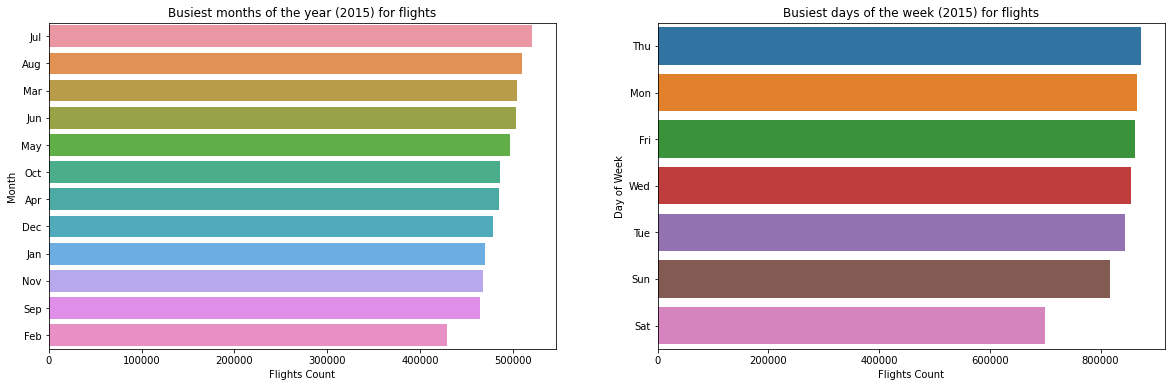

In [7]:
month_counts = flights.MONTH.value_counts()
month_counts = month_counts.rename(index={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
day_of_week_counts = flights.DAY_OF_WEEK.value_counts()
day_of_week_counts = day_of_week_counts.rename(index={1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat', 7:'Sun'})

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(hspace=0.3)
sns.barplot(month_counts.values, month_counts.index, ax=ax[0])
sns.barplot( day_of_week_counts.values, day_of_week_counts.index, ax=ax[1])
ax[0].set_ylabel("Month")
ax[0].set_xlabel("Flights Count")
ax[0].set_title("Busiest months of the year (2015) for flights")
ax[1].set_ylabel("Day of Week")
ax[1].set_xlabel("Flights Count")
ax[1].set_title("Busiest days of the week (2015) for flights")

Regarding the busiest months of the year, it's no surprise that the summer months have the most flights due to holidaymakers. But the surprise for me is with the busiest days of the week. Weekdays are more popular for flights than weekends, which isn't what I expected. I assumed people would travel during weekends more when they had time off work. 

The day/month of the flight likely plays a small role in the departure and arrival delays. More flights operating in general will usually lead to more problems and delays.

Let's look at the distribution of flights across some specific months, say January and February, to see if the number of flights is higher during certain weeks of those months.


Text(0.5, 1.0, 'Distribution of flights across the month of February')

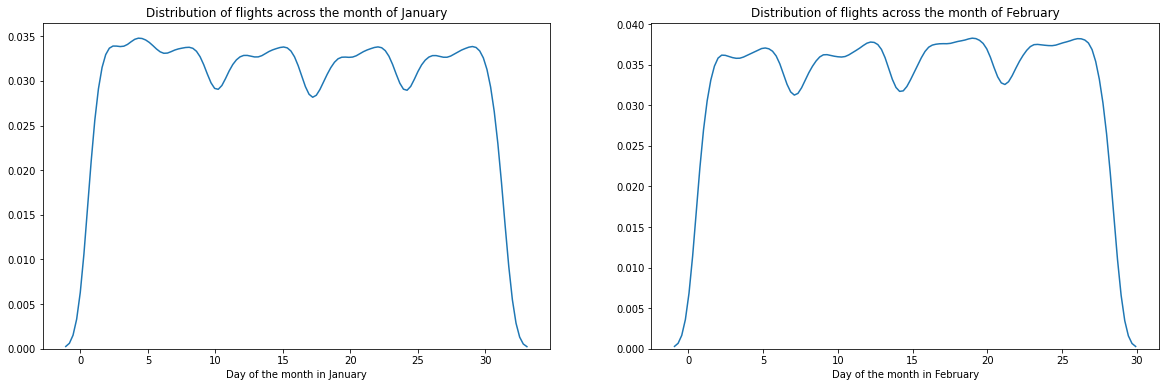

In [8]:
jan_flights = flights[flights.MONTH == 1]
feb_flights = flights[flights.MONTH == 2]


fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(hspace=0.3)
sns.distplot(jan_flights.DAY, hist=False, ax=ax[0])
sns.distplot(feb_flights.DAY, hist=False, ax=ax[1])
ax[0].set_xlabel("Day of the month in January")
ax[0].set_title("Distribution of flights across the month of January")
ax[1].set_xlabel("Day of the month in February")
ax[1].set_title("Distribution of flights across the month of February")

The distribution plots above from January and February both show consistent dips in the number of flights during the weekends. We already knew this from the previous visualisation that weekends are the least busy times for incoming/outgoing flights. January has a slightly higher number of the flights in it's first week than the rest of the month, where as February is fairly consistent throughout. 

Text(0.5, 1.0, 'Relationship between scheduled flight time and actual flight time')

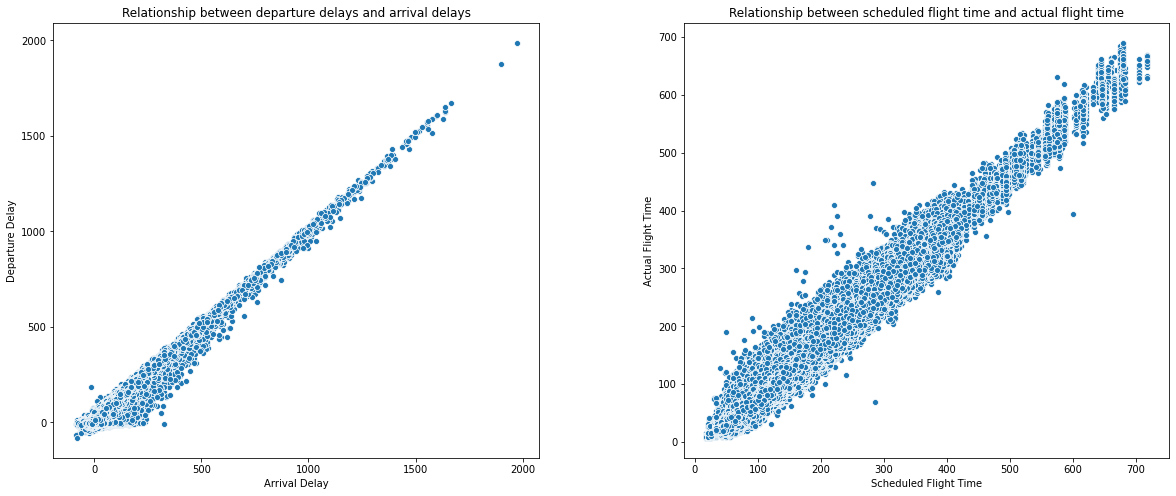

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
fig.subplots_adjust(wspace=0.3)
sns.scatterplot(x="ARRIVAL_DELAY", y="DEPARTURE_DELAY", data=flights, ax=ax[0])
sns.scatterplot(x="SCHEDULED_TIME", y="AIR_TIME", data=flights, ax=ax[1])
ax[0].set_xlabel("Arrival Delay")
ax[0].set_ylabel("Departure Delay")
ax[0].set_title("Relationship between departure delays and arrival delays")
ax[1].set_xlabel("Scheduled Flight Time")
ax[1].set_ylabel("Actual Flight Time")
ax[1].set_title("Relationship between scheduled flight time and actual flight time")

The relationship between departure delays and arrival delays is interesting, as the arrival delays tend to be slightly greater than the corresponding departure delays in the lower values (less than 500). 

The relationship between scheduled flight time and actual flight time is not very informative here. The main thing we can deduce is that there is slightly less variance for longer flight times (above 500). 

Text(0.5, 1.0, 'Mean Arrival Delay for all Airlines')

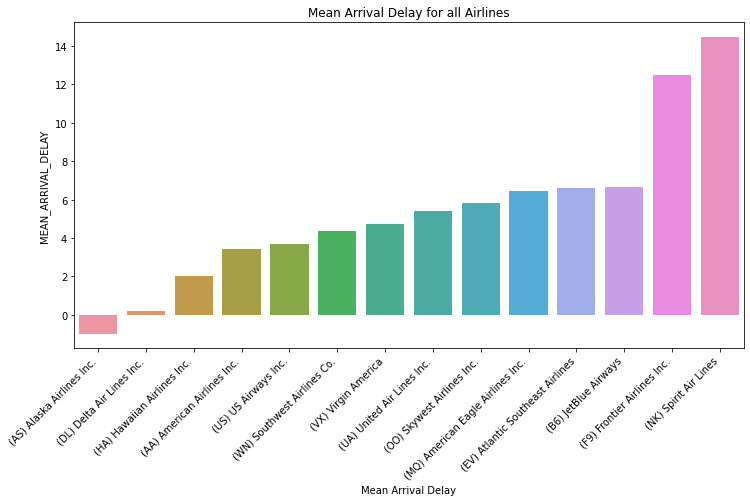

In [10]:
mean_airline_arrival_delays = flights.groupby("AIRLINE").ARRIVAL_DELAY.mean()
mean_airline_arrival_delays_data = pd.DataFrame({'IATA_CODE': list(mean_airline_arrival_delays.index), 'MEAN_ARRIVAL_DELAY': mean_airline_arrival_delays.values})
mean_airline_arrival_delays_data = mean_airline_arrival_delays_data.set_index("IATA_CODE")

mean_airline_arrival_delays_data = mean_airline_arrival_delays_data.join(airline_names)
mean_airline_arrival_delays_data['AIRLINE_CODE_NAME'] = "(" + mean_airline_arrival_delays_data.index + ") " + mean_airline_arrival_delays_data.AIRLINE
mean_airline_arrival_delays_data = mean_airline_arrival_delays_data.drop('AIRLINE', axis=1)
mean_airline_arrival_delays_data = mean_airline_arrival_delays_data.sort_values(by="MEAN_ARRIVAL_DELAY")

fig, ax = plt.subplots(figsize=(12, 6))
barplot = sns.barplot(mean_airline_arrival_delays_data.AIRLINE_CODE_NAME, mean_airline_arrival_delays_data.MEAN_ARRIVAL_DELAY, ax=ax)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("Airline")
ax.set_xlabel("Mean Arrival Delay")
ax.set_title("Mean Arrival Delay for all Airlines")

There's quite a large variation here between the lowest and highest mean arrival delay. Surprisingly, Alaska Airline's mean arrival delay is in the negative meaning their flights arrive earlier than expected on average. This could prove to be a useful new feature for the dataset when predicting arrival delays. 

# Dataset Cleaning
First and foremost this dataset contains flights that were cancelled, and therefore the data for these flights is just noise to our models. Let's remove those flights first.


In [11]:
flights = flights[flights.CANCELLED == 0]
flights.shape

(5729195, 31)

So we've lost about 100,000 flight entries that were cancelled from the dataset.

Next, I stated at the beginning that I want to predict arrival delays based off of information we would have available at take-off. This means we need to drop all features (columns in the dataset) that provide information only available after take-off. 

In [12]:
flights = flights.drop(['AIR_TIME', 'ELAPSED_TIME', 'TAXI_IN', 'WHEELS_ON', 'ARRIVAL_TIME', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'], axis=1)
flights.shape

(5729195, 18)

We're now down to 18 features, rather than 31. We've dropped features such as WHEELS_ON as we wouldn't know the time the aircraft's wheels touch the ground again until landing.

Next, let's look at the count of NULL value entries we have for each column.

In [13]:
flights.isnull().sum()

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER                0
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME             0
DEPARTURE_DELAY            0
TAXI_OUT                   0
WHEELS_OFF                 0
SCHEDULED_TIME             1
DISTANCE                   0
SCHEDULED_ARRIVAL          0
ARRIVAL_DELAY          15187
dtype: int64

To keep things simple, we're just going to drop all rows that contain a NULL value in any column.

In [14]:
flights = flights.dropna()
flights.shape

(5714008, 18)

So we've lost roughly another 15,000 entries, which is a very small number relative to the 5.7 million entries we still have. 

Finally, let's look at the head of our cleaned up dataset.

In [15]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,1448,430,-22.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,2330,750,-9.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,2296,806,5.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,2342,805,-9.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,1448,320,-21.0


# Prediction Models
Finally, we'll start work on experimenting with different models to see how closely we can predict the arrival delays of flights at take-off. 

First thing I'll do is transform all the string features with a label encoder.

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
flights['AIRLINE']= le.fit_transform(flights['AIRLINE'].astype('str'))
flights['TAIL_NUMBER']= le.fit_transform(flights['TAIL_NUMBER'].astype('str'))
flights['ORIGIN_AIRPORT'] = le.fit_transform(flights['ORIGIN_AIRPORT'].astype('str'))
flights['DESTINATION_AIRPORT'] = le.fit_transform(flights['DESTINATION_AIRPORT'].astype('str'))

Since the dataset is very large with over 5.7 million entries, it's best that we fit the models to a smaller subset of data. Therefore I'm going to use all January flights as my training set, and all February flights as my test set. We can also drop the YEAR and MONTH columns as they are constant for all the data being used.

In [17]:
jan_flights = flights[flights.MONTH == 1]
feb_flights = flights[flights.MONTH == 2]

jan_flights = jan_flights.drop(['YEAR', 'MONTH'], axis=1)
feb_flights = feb_flights.drop(['YEAR', 'MONTH'], axis=1)

X_train = jan_flights.drop('ARRIVAL_DELAY',axis=1)
y_train = jan_flights['ARRIVAL_DELAY']

X_test = feb_flights.drop('ARRIVAL_DELAY',axis=1)
y_test = feb_flights['ARRIVAL_DELAY']

print("Training set size: " + str(X_train.shape[0]))
print("Test set size: " + str(X_test.shape[0]))

Training set size: 457013
Test set size: 407663


So now we have a much smaller dataset to work with, and the training and test set are roughly the same size. 

## Linear Models
I will first start with some basic linear models, namely Linear, Lasso and Ridge regression. I shall be using the RMSE (Root Mean Squared Error) as my score metric, as this will give us an indication of how many minutes the model prediction is off by on average for the arrival delay. I'll also use cross-validation to score each model.

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_train)
print("Linear regression Training RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred))))
y_pred = linear_model.predict(X_test)
print("Linear regression Test RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))) + "\n")

params = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

ridge_model = GridSearchCV(Ridge(random_state=1), params, n_jobs=-1)
ridge_model.fit(X_train, y_train)
print("Ridge regression best parameters: {}".format(ridge_model.best_params_))
y_pred = ridge_model.best_estimator_.predict(X_train)
print("Ridge regression Training RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred))))
y_pred = ridge_model.best_estimator_.predict(X_test)
print("Ridge regression Test RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))) + "\n")

lasso_model = GridSearchCV(Lasso(random_state=1), params, n_jobs=-1)
lasso_model.fit(X_train, y_train)
print("Lasso regression best parameters: {}".format(lasso_model.best_params_))
y_pred = lasso_model.best_estimator_.predict(X_train)
print("Lasso regression Training RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred))))
y_pred = lasso_model.best_estimator_.predict(X_test)
print("Lasso regression Test RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))))

Linear regression Training RMSE: 10.414392581440527
Linear regression Test RMSE: 11.115608874429412

Ridge regression best parameters: {'alpha': 1000}
Ridge regression Training RMSE: 10.414392584188205
Ridge regression Test RMSE: 11.115610288292627

Lasso regression best parameters: {'alpha': 0.1}
Lasso regression Training RMSE: 10.41456567741417
Lasso regression Test RMSE: 11.113470138839457


These linear models provide us with a nice baseline for our Test RMSE, with Lasso scoring the smallest RMSE at 11.113. This effectively means that on average, the predictions are roughly 11 minutes out of the real arrival delays in y_test. 

## Tree Models
Next I will try using Decision Trees/Random Forests to see if I can get a lower RMSE score.

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

dt = DecisionTreeRegressor(random_state=1)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_train)
print("Decision Tree Training RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred))))
y_pred = dt.predict(X_test)
print("Decision Tree Test RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))) + "\n")

params = {"n_estimators": [10, 25, 50]}

rf_gscv = GridSearchCV(RandomForestRegressor(random_state=1), params, n_jobs=-1)
rf_gscv.fit(X_train, y_train)
print("Random Forest best parameters: {}".format(rf_gscv.best_params_))
y_pred = rf_gscv.best_estimator_.predict(X_train)
print("Random Forest Training RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred))))
y_pred = rf_gscv.best_estimator_.predict(X_test)
print("Random Forest Test RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))))

Decision Tree Training RMSE: 0.0
Decision Tree Test RMSE: 15.408000132645755

Random Forest best parameters: {'n_estimators': 50}
Random Forest Training RMSE: 3.687889487207703
Random Forest Test RMSE: 11.028406548332692


The Decision Tree test RMSE is disappointingly higher than the linear models, at roughly 15 minutes inaccuracy on average. However a Random forest with 50 estimators achieved a slightly better RMSE score of 11.028. 

## Extreme Gradient Boosting (XGB)
I'll try using an extreme gradient boosting model built using trees, to see if we get any further improvements.

In [20]:
from xgboost import XGBRegressor

params = {"n_estimators": [250, 500], "learning_rate": [0.01, 0.1]}

xgb_gscv = GridSearchCV(XGBRegressor(random_state=1), params, n_jobs=-1)
xgb_gscv.fit(X_train, y_train)
print("XGB best parameters: {}".format(xgb_gscv.best_params_))
y_pred = xgb_gscv.best_estimator_.predict(X_train)
print("XGB Training RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred))))
y_pred = xgb_gscv.best_estimator_.predict(X_test)
print("XGB Test RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))))

XGB best parameters: {'learning_rate': 0.1, 'n_estimators': 250}
XGB Training RMSE: 8.695759633495875
XGB Test RMSE: 10.713545447950304


Using XGB has once again slightly improved the RMSE to 10.714. 

One last thing I can try to improve this score is by adding an extra feature to dataset, which is the mean arrival delay for the airline in January. In order to avoid data leakage, this mean will only be calculated over the January training set, and the same mean values will be added onto the February test set. February's data will not be used in order to stop test data leaking into the model. 

In [21]:
mean_airline_arrival_delay_in_january = jan_flights.groupby("AIRLINE").ARRIVAL_DELAY.mean()
mean_airline_arrival_delay_in_january_data = pd.DataFrame({"AIRLINE": list(mean_airline_arrival_delay_in_january.index), "MEAN_ARRIVAL_DELAY": mean_airline_arrival_delay_in_january.values})
mean_airline_arrival_delay_in_january_data = mean_airline_arrival_delay_in_january_data.set_index("AIRLINE")
jan_flights = jan_flights.set_index("AIRLINE")
jan_flights = jan_flights.join(mean_airline_arrival_delay_in_january_data)
jan_flights = jan_flights.reset_index()
feb_flights = feb_flights.set_index("AIRLINE")
feb_flights = feb_flights.join(mean_airline_arrival_delay_in_january_data)
feb_flights = feb_flights.reset_index()

X_train = jan_flights.drop('ARRIVAL_DELAY',axis=1)
y_train = jan_flights['ARRIVAL_DELAY']

X_test = feb_flights.drop('ARRIVAL_DELAY',axis=1)
y_test = feb_flights['ARRIVAL_DELAY']

In [22]:
xgb = XGBRegressor(n_estimators=250, learning_rate=0.1, random_state=1, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
print("XGB Training RMSE: " + str(np.sqrt(mean_squared_error(y_train, y_pred))))
y_pred = xgb.predict(X_test)
print("XGB Test RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))))

XGB Training RMSE: 8.69368412735377
XGB Test RMSE: 10.690030265811886


Adding this extra feature improved the RMSE score but only very slightly, to 10.690. 
## Conclusion 
So my final best RMSE score, using an XGBRegressor model was 10.690. This means on average, the model's prediction is roughly 10.7 minutes off the actual arrival delay. 10.7 minutes is not a particularly great error margin, especially for shorter flights. 

To improve it further, I would either need to create more features that would be useful to the model. Extra features may also need to be provided in the original dataset, such as the expected weather conditions for a flight. This information could provide extra insights for the model to provide better predictions. 

Using a larger amount of training data is also a possibility, seeing as I have only used the month of January. However these models were already quite slow to train thus more data is going to drastically increase the computational effort required to fit the models, especially with more features too. 